<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP_2022/blob/main/05 Deep Learning/notebooks/5-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Clasificación con Redes Neuronales Convolucionales</h1>

En esta notebook usaremos una red neuronal convolucional (CNN) para clasificar el dataset *cats vs dogs* de kaggle. Observaremos, además, el efecto del dropout y analizaremos la información de las capas ocultas para ganar intuición sobre el funcionamiento interno de este tipo de redes.

___

&#128214; <u>Referencias bibliográficas y sitios de interés</u>:
* Ian Goodfellow, Yoshua Bengio, and Aaron Courville. 2016. Deep Learning. The MIT Press.
* [Keras an API for Tensorflow](https://keras.io/getting_started/)
* [Tensorflow: end-to-end open source machine learning platform](https://www.tensorflow.org/)
* [Deep Learning with Keras and TensorFlow](https://www2.mpia-hd.mpg.de/homes/dgoulier/MLClasses/Course%20-%20Deep%20Learning%20with%20Keras%20and%20TensorFlow%20-%20Part%201.html)

Verifiquemos que el entorno de ejecución en Colab sea GPU

In [ ]:
import tensorflow as tf

print('GPU presente en: {}'.format(tf.test.gpu_device_name()))

GPU presente en: /device:GPU:0


# [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/overview)

El conjunto de datos de Dogs vs Cats fue publicado por Kaggle.com como parte de una competencia de visión computacional a fines de 2013, cuando las CNNs no eran muy comunes.

Se puede descargar el dataset original en: https://www.kaggle.com/c/dogs-vs-cats/data (se necesita crear una cuenta de Kaggle).

Esta notebook se puede usar con dos conjuntos de datos:

* Usaremos el conjunto de datos original de entrenamiento, dado que contiene las etiquetas de las clases. Este conjunto contiene 25,000 imágenes de perros y gatos (12,500 de cada clase) y tiene un tamaño de 543 MB. Ya se encuentra dividido en *train*, *validation* y *test*. [Download](https://drive.google.com/file/d/1Q3xOfn2Up9uIOLviS66oYH_oFFK-IGpW/view?usp=sharing)

* Usaremos un conjunto reducido de datos, el cual contiene 1000 imágenes de cada clase para entrenamiento, 500 para validación y 500 para prueba. Todos los datos se sacaron del conjunto de entrenamiento original. [Download](https://drive.google.com/file/d/1Ce3u8dwYYriLkz5OpcGn72xIQENIHZX5/view?usp=sharing)

# Datos

Copiaremos el dataset desde un vínculo de Google Drive

In [ ]:
!pip install -qq gdown

Descargamos el dataset desde Google Drive

In [ ]:
# ----- Versión completa -----
# !gdown --id 1Q3xOfn2Up9uIOLviS66oYH_oFFK-IGpW

# ----- Copia de la versión completa -----
# !gdown 1hchhNQ_3WNncaXVD3kX58EIppcYFt-E2

# ----- Versión reducida -----
!gdown 1Ce3u8dwYYriLkz5OpcGn72xIQENIHZX5

# ----- Versión reducida -----
# !gdown 1NK9LvrVwsEQM0UHkFHq_GYCF2fjGrwAP

Downloading...
From: https://drive.google.com/uc?id=1NK9LvrVwsEQM0UHkFHq_GYCF2fjGrwAP
To: /content/cnn_perros_gatos-small-copia.zip
100% 91.1M/91.1M [00:00<00:00, 205MB/s]


Descomprimimos

In [ ]:
from zipfile import ZipFile

# file_name = '/content/cnn_perros_gatos.zip'
# file_name = '/content/cnn_perros_gatos-copia.zip'
file_name = '/content/cnn_perros_gatos-small.zip'
# file_name = '/content/cnn_perros_gatos-small-copia.zip'

with ZipFile(file_name, 'r') as myzip:
    myzip.extractall()
    print('Listo')

Listo


Exploramos las carpetas de entrenamiento, validación y prueba.

In [ ]:
import os, shutil

train_dogs = 'cnn_perros_gatos/train/dogs'
print('Para entrenamiento:')
print('{} Perros.'.format(len(os.listdir(train_dogs))))
train_cats = 'cnn_perros_gatos/train/cats'
print('{} Gatos.'.format(len(os.listdir(train_cats))))
print('\nPara validación:')
validation_dogs = 'cnn_perros_gatos/validation/dogs'
print('{} Perros.'.format(len(os.listdir(validation_dogs))))
validation_cats = 'cnn_perros_gatos/validation/cats'
print('{} Gatos.'.format(len(os.listdir(validation_cats))))
print('\nPara prueba:')
test_dogs = 'cnn_perros_gatos/test/dogs'
print('{} Perros.'.format(len(os.listdir(test_dogs))))
test_cats = 'cnn_perros_gatos/test/cats'
print('{} Gatos.'.format(len(os.listdir(test_cats))))

Para entrenamiento:
1000 Perros.
1000 Gatos.

Para validación:
500 Perros.
500 Gatos.

Para prueba:
500 Perros.
500 Gatos.


Definimos los directorios de entrenamiento, validación y prueba para usaralos en el resto de la notebook.

In [ ]:
train_dir = 'cnn_perros_gatos/train'
validation_dir = 'cnn_perros_gatos/validation'
test_dir = 'cnn_perros_gatos/test'

# Modelo

Definimos un primer modelo de CNN. Usaremos las capas `Conv2D` para las operaciones de convolución y `MaxPooling2D` para el pooling.

* https://keras.io/api/layers/convolution_layers/convolution2d/
* https://keras.io/api/layers/pooling_layers/max_pooling2d/

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', 
                           input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

* NOTA que comenzamos con imágenes de tamaño 150 x 150 (una elección de tamaño arbitraria) y terminamos con mapas de características de tamaño 7 x 7 justo antes de la capa de *flatten*.
* En realidad las imágenes de entrada tienen tamaños diversos (desconocidos), pero afortunadamente Keras nos puede ayudar a pre-procesarlas.

Compilamos el modelo

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


# Preprocesamiento de datos


Los datos deben formatearse en tensores de punto flotante preprocesados adecuadamente antes de que se introduzcan en la red. En este momento, nuestros datos se encuentran almacenados como archivos JPEG, por lo que los pasos para que puedan ser introducidos en nuestra red son:

* Leer los archivos de imagen.

* Decodificar el contenido JPEG a cuadrículas de píxeles RBG.

* Convertirlos en tensores de punto flotante.

* Volver a escalar los valores de píxeles (entre 0 y 255) al intervalo $[0, 1]$ (las redes neuronales prefieren tratar con valores de entrada pequeños).

Afortunadamente, Keras tiene herramientas para encargarse de estos pasos automáticamente. Keras tiene un módulo con herramientas de ayuda para procesamiento de imágenes, ubicado en **keras.preprocessing.image**. En particular, contiene la clase **ImageDataGenerator**, que permite configurar rápidamente los generadores de Python que pueden convertir automáticamente los archivos de imagen en disco en *batches* de tensores preprocesados.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Todas las imágenes serán reescaladas por 1./255.
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Este es el directorio de origen
        train_dir,
        # Todas las imágenes se redimensionarán a 150 x 150
        target_size=(150, 150),
        batch_size=20,
        # Ya que usamos la función de pérdida de entropía cruzada binaria, 
        # necesitamos etiquetas binarias
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


* Vamos a revisar la salida de uno de estos generadores: produce batches de imágenes de 150 x 150 RGB (con la forma (20, 150, 150, 3)) y etiquetas binarias (con la forma (20,)). 20 es el número de muestras en cada batch (el tamaño del batch). 
* Como el generador genera estos batches de forma indefinida (i.e. recorre sin fin las imágenes presentes en la carpeta que se le indicó), se necesita romper el loop de iteración en algún punto.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('Dimensiones del batch de imágenes:', data_batch.shape)
    print('Dimensiones del batch de las etiquetas:', labels_batch.shape)
    break

Dimensiones del batch de imágenes: (20, 150, 150, 3)
Dimensiones del batch de las etiquetas: (20,)


* Vamos a proceder a entrenar nuestro modelo con los datos usando el generador. Debido a que los datos se generan infinitamente, el generador necesita saber cuántas muestras extraer antes de declarar una época finalizada. Esta es la función del argumento **steps_per_epoch** 

* En este caso, **steps_per_epoch** corresponde al número de batches que requiere el generador para leer el conjunto de datos completo. Sólo después de haber solicitado este número de batches, el proceso de ajuste de nuestro modelo pasará a la siguiente época. **steps_per_epoch** corresponde a el número de pasos de descenso del gradiente. En nuestro caso, cada batch tiene un tamaño de 20 muestras, por lo que tomará 100 pasos (batches) hasta que cubramos las 2,000 muestras de nuestra base de datos.

* Como siempre, uno puede pasar un argumento llamado **validation_data**. Es importante destacar que este argumento puede ser un generador de datos en sí mismo, pero también podría ser una tupla de arreglos Numpy. Si se pasa un generador como **validation_data**, entonces se espera que este generador produzca batches de datos de validación sin fin, y por lo tanto también se debe especificar el argumento **validation_steps**, que le dice al proceso cuántos batches debe extraer del generador de validación para su evaluación.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 22s 94ms/step - loss: 0.6912 - accuracy: 0.5380 - val_loss: 0.6861 - val_accuracy: 0.5350
Epoch 2/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6557 - accuracy: 0.6160 - val_loss: 0.6441 - val_accuracy: 0.6300
Epoch 3/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6172 - accuracy: 0.6525 - val_loss: 0.6205 - val_accuracy: 0.6490
Epoch 4/30
100/100 [==============================] - 10s 96ms/step - loss: 0.5776 - accuracy: 0.6980 - val_loss: 0.5904 - val_accuracy: 0.6820
Epoch 5/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5430 - accuracy: 0.7270 - val_loss: 0.5896 - val_accuracy: 0.6850
Epoch 6/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5083 - accuracy: 0.7550 - val_loss: 0.5789 - val_accuracy: 0.6930
Epoch 7/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4819 - accuracy: 0.7655 - val_loss: 0.5518 - val_accuracy: 0.70

## Verificación de resultados

Guardamos el modelo

In [ ]:
model.save('cnn_perros_gatos_1.h5')

Grafiquemos las curvas de aprendizaje

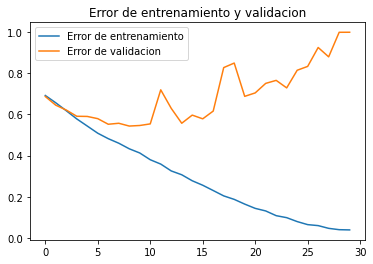

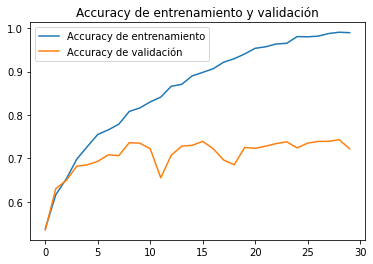

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, label='Error de entrenamiento')
plt.plot(epochs, val_loss, label='Error de validacion')
plt.title('Error de entrenamiento y validacion')
plt.legend()

plt.figure()

plt.plot(epochs, acc, label='Accuracy de entrenamiento')
plt.plot(epochs, val_acc, label='Accuracy de validación')
plt.title('Accuracy de entrenamiento y validación')
plt.legend()

plt.show()

# Aumento de Datos

* El efecto de sobreajuste ocurre cuando se tienen muy pocas muestras de las que aprender, lo que nos impide entrenar un modelo capaz de generalizar a nuevos datos. Si tuviesemos datos infinitos, nuestro modelo estaría expuesto a todos los aspectos posibles de la distribución de datos en cuestión y nunca se sobreajustaría nuestro modelo. 

* El aumento de datos adopta el enfoque de generar más datos de entrenamiento a partir de muestras de entrenamiento existentes, al "aumentar" las muestras a través de una serie de transformaciones aleatorias que producen imágenes de apariencia creíble. El objetivo es que durante el tiempo de entrenamiento, nuestro modelo nunca vea exactamente la misma imagen dos veces. Esto ayuda a que el modelo se exponga a más aspectos de los datos y generalice mejor.

* En Keras, esto se puede hacer configurando una serie de transformaciones aleatorias que se realizarán en las imágenes leídas por nuestra instancia de ImageDataGenerator.

* Vamos a comenzar por aumentar una imagen.



In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

Las opciones anteriores son solo algunas de las opciones disponibles.

* **rotation_range** es un valor en grados (0-180), un rango dentro del cual girar las imágenes de forma aleatoria.

* **width_shift** y **height_shift** son rangos expresados como una fracción del ancho o altura total de la imagen, dentro de los cuales se pueden trasladar vertical u horizontalmente de forma aleatoria a las imágenes.

* **shear_range** aplica aleatoriamente transformaciones de corte.

* **zoom_range** aplica acercamientos aleatorios dentro de las imágenes.

* **horizontal_flip** Voltea de forma aleatoria la mitad en las imágenes horizontalmente.

* **fill_mode** es la estrategia utilizada para rellenar píxeles creados, que pueden aparecer después de una rotación o un cambio de ancho / altura.

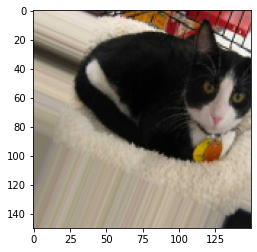

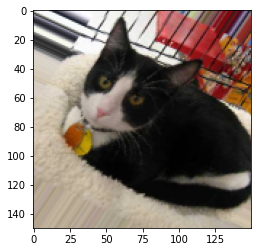

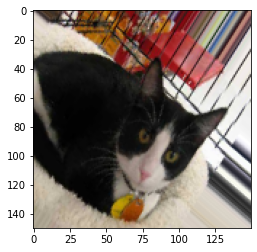

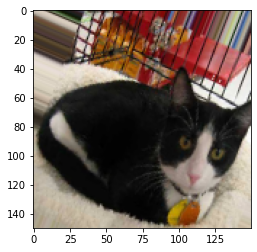

In [ ]:
# Módulo con métodos para preprocesamiento de imágenes.
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Escogemos una imagen para aplicar el "aumentado de datos"
img_path = fnames[7]

# Leemos la imagen y la redimensionamos.
img = image.load_img(img_path, target_size=(150, 150))

# Convertimos la imagen en un arreglo de Numpy de dimensiones (150, 150, 3)

x = image.img_to_array(img)

# Redimensionamos el arreglo a (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# El comando .flow () genera batches de imágenes transformadas aleatoriamente
# Con el "for" de abajo estaremos en un loop indefinidamente, 
# Vamos a necesitar 'romper' el loop en algún momento

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

* Si entrenamos una nueva red neuronal utilizando esta configuración de aumento de datos, nuestra red nunca verá dos veces la misma entrada, pues a cada nueva imagen se le aplica transformaciones aleatorias dentro de ciertos rangos. 

* Sin embargo, las entradas que ves están aún muy interrelacionadas, ya que provienen de un pequeño número de imágenes originales: **no podemos producir nueva información, sólo podemos mezclar la información existente**. 

* Dado que esto podría no ser suficiente para librarnos del sobreajuste. Para mitigarlo aún más, también agregaremos una capa de Dropout a nuestro modelo, justo antes de la etapa del clasificador densamente conectado (fully-connected).

Definimos una nueva red, usando capas de dropout.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 17, 17, 128)     

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Definimos los nuevos generadores de imágenes

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Debemos notar que los datos del conjunto validación no son sometidos 
# al aumentado de datos

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Esta es la carpeta de origen
        train_dir,
        # Todas las imágenes se redimensionarán a 150 x 150 
        target_size=(150, 150),
        batch_size=20,
        # Dado que usamos la función de entropía cruzada binaria, 
        # necesitamos etiquetas binarias
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

# Observación, para mejores resultados entrenar con epochs = 100
# Por cuestiones de tiempo se entrena con epochs = 30

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/30
100/100 - 21s - loss: 0.6968 - accuracy: 0.5110 - val_loss: 0.6888 - val_accuracy: 0.5880 - 21s/epoch - 211ms/step
Epoch 2/30
100/100 - 18s - loss: 0.6903 - accuracy: 0.5335 - val_loss: 0.6826 - val_accuracy: 0.5260 - 18s/epoch - 181ms/step
Epoch 3/30
100/100 - 18s - loss: 0.6876 - accuracy: 0.5345 - val_loss: 0.6728 - val_accuracy: 0.5920 - 18s/epoch - 180ms/step
Epoch 4/30
100/100 - 20s - loss: 0.6819 - accuracy: 0.5690 - val_loss: 0.6640 - val_accuracy: 0.6170 - 20s/epoch - 202ms/step
Epoch 5/30
100/100 - 20s - loss: 0.6624 - accuracy: 0.6045 - val_loss: 0.6687 - val_accuracy: 0.6040 - 20s/epoch - 202ms/step
Epoch 6/30
100/100 - 18s - loss: 0.6577 - accuracy: 0.6085 - val_loss: 0.6564 - val_accuracy: 0.6090 - 18s/epoch - 177ms/step
Epoch 7/30
100/100 - 18s - loss: 0.6437 - accuracy: 0.6355 - val_loss: 0.6625 - val_accuracy: 0.6090 - 18s/epoch - 178ms/step
Epoch 8/30
100/100 - 18s - loss: 

In [ ]:
# Descomentar la siguiente linea si entrenaste con epochs = 100
model.save('cnn_perros_gatos_2.h5')

Veamos las curvas de entrenamiento

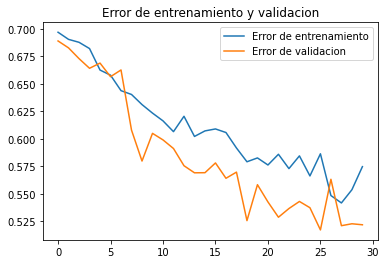

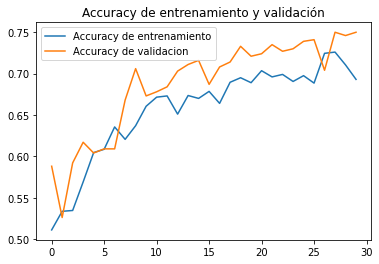

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, label='Error de entrenamiento')
plt.plot(epochs, val_loss, label='Error de validacion')
plt.title('Error de entrenamiento y validacion')
plt.legend()

plt.figure()

plt.plot(epochs, acc,label='Accuracy de entrenamiento')
plt.plot(epochs, val_acc,label='Accuracy de validacion')
plt.title('Accuracy de entrenamiento y validación')
plt.legend()

plt.show()

# ¿Qué pasaría si entrenas con 100 épocas?

Con epochs = 100 se obtendrían los siguientes resultados:

![](https://drive.google.com/uc?id=11R0eVCGKX3Av7fqDEmpqJ5WQ3XtyOMpS)


# Parte II - Visualizando los mapas de características de una red neuronal convolucional

Algunos señalan que los modelos de aprendizaje profundo funcionan como "cajas negras", pues aprenden representaciones que son difíciles de extraer y presentar de una forma legible para el ser humano. 

Si bien esto es parcialmente cierto para algunos tipos de modelos de aprendizaje profundo, definitivamente no lo es para las redes convolucionales (*CNN*). Las representaciones aprendidas por las redes convolucionales son altamente susceptibles de visualización, en gran parte porque son representaciones de conceptos visuales. Desde 2013, se ha desarrollado una amplia gama de técnicas para visualizar e interpretar estas representaciones. No exploraremos todas ellas, pero mencionaremos tres de las más accesibles y útiles:



*   **Visualización de las salidas intermedias de una *CNN*  ("activaciones intermedias")**. Este método es útil para entender cómo las capas sucesivas de una red convolucional transforman su entrada y para obtener una noción de la función de los filtros individuales en una red convolucional .

*   **Visualización de los  filtros en una CNN**. Este método es útil para entender con precisión a qué patrón o concepto visual es receptivo cada filtro en una red convolucional.

*   **Visualización de los mapas de calor de activación por clase en una imagen**. Este método es útil para entender qué parte de una imagen se identificó como perteneciente a una clase determinada y, por lo tanto, permite localizar objetos en imágenes.

En este ejercicio, abordaremos únicamente el primer método, la visualización de las activaciones intermedias o mapas de características. Para ello, usaremos la pequeña CNN que entrenamos desde cero en el problema de clasificación de perros y gatos.



In [ ]:
# model = tf.keras.models.load_model('Data/cnn_perros_gatos_2.h5')
# Para recordar nuestro modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 128)     

### &#9998; Vamos a seleccionar una imagen de entrada, puede ser cualquier imagen del **conjunto de test**.

* En este ejemplo, usaremos la imagen de un gato. Por ser del conjunto de test, no forma parte de las imágenes sobre las que se entrenó la red:



In [ ]:
from keras.preprocessing import image
import numpy as np

# ----- Para el conjunto de datos completo ----
# img_path = 'cnn_perros_gatos/test/cats/cat.147.jpg'   # Una imágen de un gato
# img_path = 'cnn_perros_gatos/test/dogs/dog.1517.jpg'    # Una imágen de un perro

# ----- Para el conjunto de datos reducido ----
# img_path = '/content/cnn_perros_gatos/test/cats/cat.10128.jpg'
img_path = '/content/cnn_perros_gatos/test/dogs/dog.10086.jpg'

# ----- Preprocesamos la imagen en un tensor 4D

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

# ----- Debemos recordar que el modelo fue entrenado con imagenes de entrada preprocesadas de la siguiente manera:
img_tensor /= 255.

# Debemos ver que su forma es de (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


Mostramos la imágen

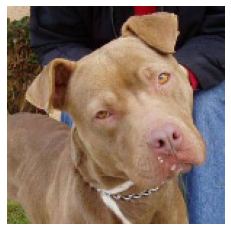

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.axis('Off')
plt.show()

* Para extraer los mapas de características que queremos visualizar, crearemos un modelo de Keras que toma lotes ó *batches* de imágenes como entrada y genera las activaciones de todas las capas de convolución y *pooling*. 
* Para ello, utilizaremos la clase de Keras **Model**, que ya vimos anteriormente. Un **model** se instancia mediante dos argumentos: un tensor de entrada (o lista de tensores de entrada) y un tensor de salida (o lista de tensores de salida). La clase resultante es un modelo de Keras, igual que los modelos secuenciales (Sequential models) que ya estudiamos, que mapea las entradas especificadas a las salidas especificadas. Lo que distingue a la clase **Model** es que permite modelos con múltiples salidas, a diferencia de **Sequential**.

In [ ]:
# Extraemos las salidas de las 8 capas superiores:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creamos un modelo que devolverá estas salidas, dada la entrada al modelo:
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

* Cuando se introduce una imagen como entrada a la red, este modelo devuelve los valores de las activaciones de las capas del modelo original. Hasta antes de esta sección del ejercicio, el modelo que se presentó sólo tenía exactamente una entrada y una salida. Ahora estamos introduciendo el concepto de un modelo con múltiples salidas.

* En el caso general, un modelo podría tener cualquier número de entradas y salidas. Este último modelo tiene una entrada y 8 salidas, una salida por capa de activación.

In [ ]:
# Esto devolverá una lista de arreglos de Numpy: Un arreglo por capa de activación
activations = activation_model.predict(img_tensor)

Por ejemplo, vamos a imprimir las dimensiones  del mapa de características/activaciones de la primer capa convolucional para la imagen del gato:

In [ ]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


Es un mapa de características con una dimensión de 148 x 148 con 32 canales o profundidad. 

Vamos a visualizar el 3er canal de ese mapa de características.

Nota: En Python, los arreglos comienzan en 0, por lo que para acceder al canal 1, lo haríamos con el índice 0.

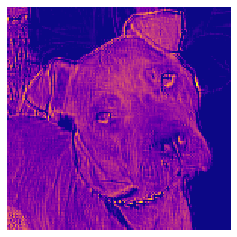

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 2], cmap='plasma')
plt.axis('Off')
plt.show()

### &#9998; Probemos algún otro canal, pero debemos tener en cuenta que los canales que tenga uno pueden variar de los que tiene cualquier otro, ya que los filtros que en específico aprende la red en las capas convolucionales no son determinísticos.

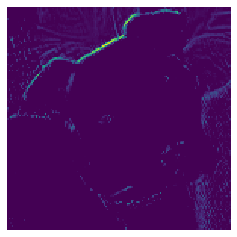

In [ ]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.axis('Off')
plt.show()

Finalmente, vamos a desplegar un gráfico completo de todas las activaciones en la red. En otras palabras, vamos a extraer y mostrar cada canal presente en cada uno de nuestros 8 mapas de características. Apilaremos los resultados en un gran tensor de imagen, con los canales colocados uno junto al otro.



Primero, guardamos los nombres de las capas

In [ ]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

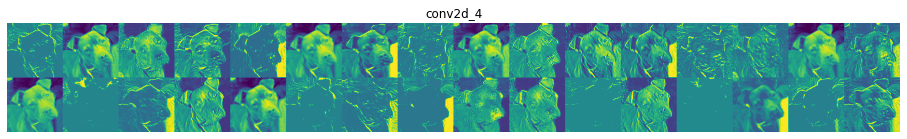

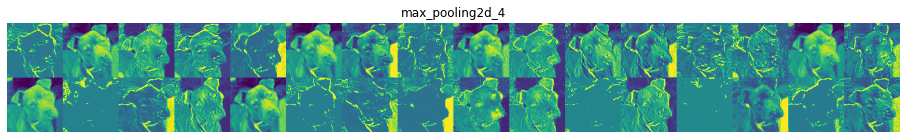

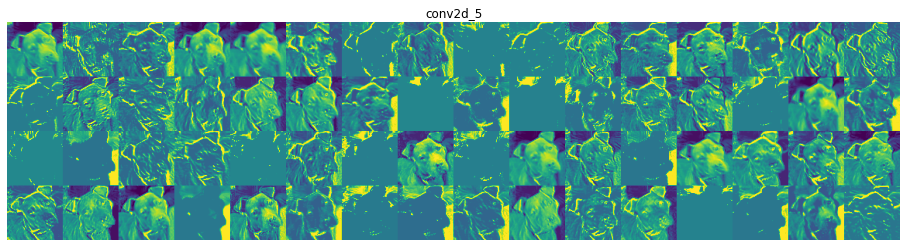

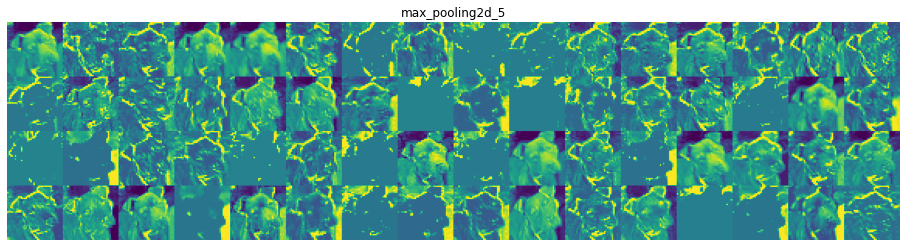

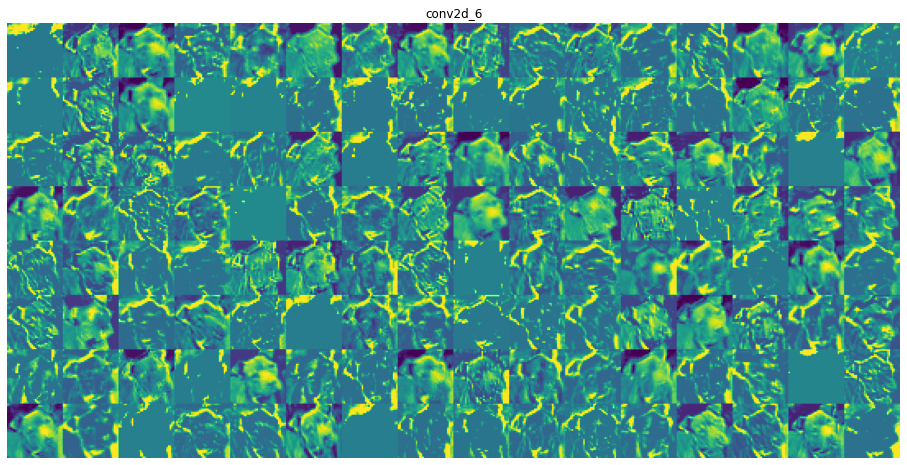

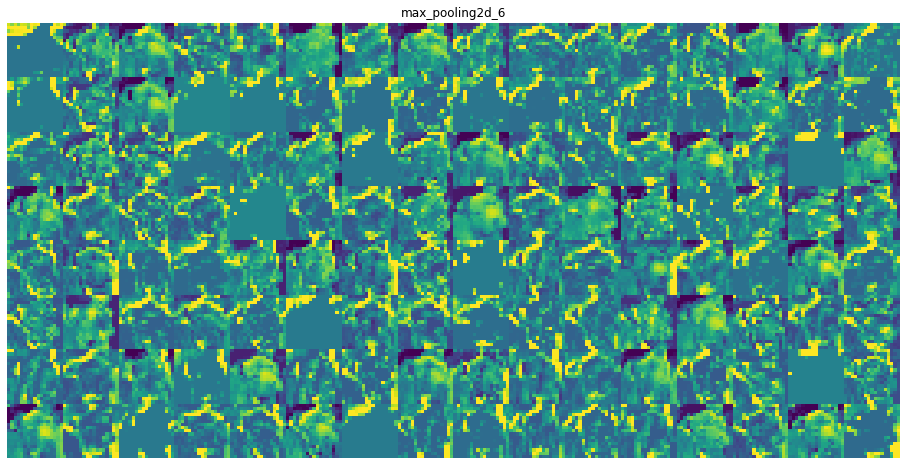

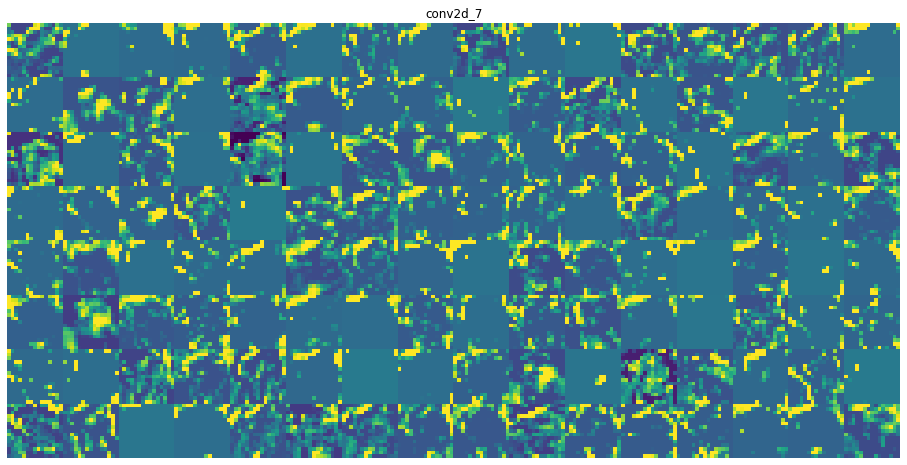

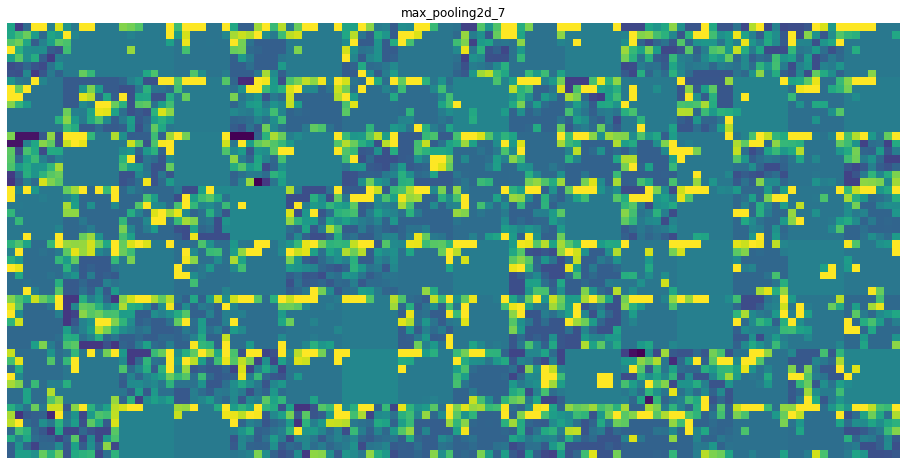

In [ ]:
for layer_name, layer_activation in zip(layer_names, activations):
    # Este es el número de características presentes en un mapa de características
    n_features = layer_activation.shape[-1]

    # El mapa de características tiene la forma: (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Vamos a colocar los canales de activación en esta matriz
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Colocaremos cada mapa en esta gran malla horizontal
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            
            # Procesaremos el mapa de características para que sea visualmente agradable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Mostramos los mapas en la malla
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis('Off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

# Observaciones

Del gráfico de mapas de características podemos notar lo siguiente:

* La primera capa de la red actúa como una colección de varios detectores de borde. En esa etapa, las activaciones aún retienen casi toda la información presente en la imagen inicial.

* A medida que avanzamos en profundidad, las activaciones se vuelven cada vez más abstractas y menos interpretables visualmente. Se comienzan a codificar conceptos de nivel superior como "oreja de gato" u "ojo de gato". Las representaciones superiores llevan cada vez menos información sobre el contenido visual de la imagen, y cada vez más información relacionada con la clase de la imagen.

* La escasez de activaciones aumenta con la profundidad de la red: en la primera capa, todos los filtros se activan mediante la imagen de entrada, pero en las siguientes capas, más y más canales de activación están en blanco. Esto significa que el patrón codificado por el filtro no se encuentra en la imagen de entrada.

# Comentarios Finales

Acabamos de evidenciar un hecho muy importante de las representaciones aprendidas por las redes neuronales profundas: las características extraídas por una capa se vuelven cada vez más abstractas con la profundidad de la red. 

Las activaciones de las capas superiores contienen cada vez menos información sobre la entrada específica que se está viendo y más información sobre el objetivo (en el caso de este ejemplo, la clase de la imagen: gato o perro). Una red neuronal profunda actúa efectivamente como un *pipeline* (tubería) que destila la información, con datos en crudo que entran (en nuestro caso, imágenes RBG) y se transforman repetidamente de tal forma que la información irrelevante es filtrada (por ejemplo, la apariencia visual específica de la imagen) mientras que la información útil es magnificada y refinada (por ejemplo, la clase de la imagen).

Esto es análogo a la forma en que los humanos y los animales perciben el mundo: después de observar una escena durante unos segundos, un humano puede recordar qué objetos abstractos estaban presentes en él (por ejemplo, una bicicleta, un árbol) pero muchas veces no puede recordar la apariencia específica de estos objetos.

El cerebro ha aprendido a abstraer completamente la información visual, a transformarla en conceptos visuales de alto nivel mientras filtra por completo los detalles visuales irrelevantes, haciendo que sea tremendamente difícil recordar cómo se ven exactamente las cosas a nuestro alrededor.
